In [11]:
import logging, os
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from pathlib import Path
import json
import pandas as pd

from PIL import ImageFont, Image
import visualkeras

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import keras_tuner as kt
import tensorflow as tf

import hyper_model_creator

In [12]:
figures_dir = Path('report', 'figures', 'figures_tuner')

In [13]:
trials_dir = Path('trials', 'hyperband_resnet_followup')
trials_metric = 'val_weightedf2score'
hypermodel = hyper_model_creator.BuildHyperModel(trials_dir, trials_metric)

tuner = kt.Hyperband(
    hypermodel,
    objective=kt.Objective(trials_metric, direction='max'),
    directory=trials_dir.parent,
    project_name=trials_dir.name,
)
hp = tuner.oracle.get_space()

Reloading Tuner from trials/hyperband_resnet_followup/tuner0.json


In [15]:
# tuner.get_best_models(num_models=1)

In [16]:
rows = []
for p in hp.space:
    config = p.get_config()
    rows.append(config)

search_space = pd.DataFrame(rows)[['name', 'values']].fillna('[true, false]').astype('string')
for c in search_space.columns: 
    search_space[c] = search_space[c].str.replace('_', '\\_')

tex = search_space.to_latex(
    index=False,
    caption='Summary of initial hyperparameter search space.',
    label=f'tab:{trials_dir.name}_params',
)
tex = tex.split('\n')
tex.insert(3, f'\centering\n')

with open(figures_dir.joinpath(f'{trials_dir.name}_params.tex'), 'w') as f:
    f.write('\n'.join(tex))

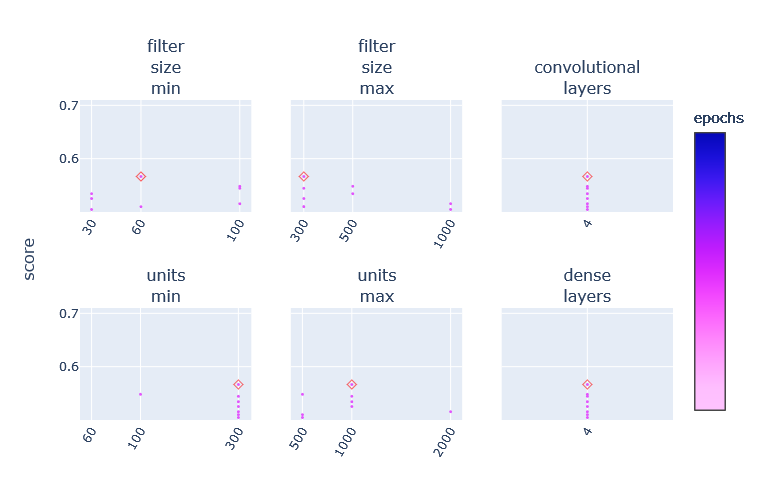

In [36]:
rows = []
for trial in sorted(list(trials_dir.glob('trial_*'))):
    with open(trial.joinpath('trial.json')) as f:
        results = json.load(f)
        row = {'score': results['score']} | results['hyperparameters']['values']
        rows.append(row)

trials_df = pd.DataFrame(rows).sort_values(by='score', ascending=False)
trials_df = trials_df.rename({'tuner/epochs': 'epochs'}, axis=1)
trials_df = trials_df[[c for c in trials_df.columns if 'tuner' not in c]]

nrows, ncols = 2, 3
fig = make_subplots(
    rows=nrows, cols=ncols, shared_yaxes='all', y_title='score',
    subplot_titles=trials_df.columns[1:].str.replace('_', '<br>'),
    vertical_spacing=0.3,
)

for i, col in enumerate(trials_df.columns[1:].drop('epochs')):
    if trials_df[col].dtype == object:
        x = trials_df[col].str.replace('_', '<br>')
    else:
        x = trials_df[col]

    position = dict(row=(i//ncols)+1, col=(i%ncols)+1)
    fig.append_trace(go.Scatter(
        y=trials_df['score'],
        x=x,
        mode='markers',
        marker=dict(
            color=trials_df['epochs'],
            size=3,
            showscale=True,
            colorscale='Plotly3_r',
            colorbar_title='epochs',
            colorbar_tickvals=[trials_df['epochs'].min(), trials_df['epochs'].max()]
        ),
        opacity=0.8,
    ), **position)
    
    fig.append_trace(go.Scatter(
        y=[trials_df['score'].max()],
        x=[x[trials_df['score'].idxmax()]],
        mode='markers',
        marker_symbol='diamond-open',
        marker_color='red',
        marker_size=7,
        opacity=0.6,
    ), **position)

    fig.update_xaxes(
        type='log' if 'learning_rate' in col else None,
        tickformat='.1r',
        tickangle=-60,
        tickvals=x.unique(),
        **position
    )
    fig.update_yaxes(range=[0.5, 0.71], tickvals=[0.6, 0.7])

fig.update_layout(
    height=500, width=700, showlegend=False,
    margin=dict(l=80, r=80, t=100, b=80)
)

fig.write_image(figures_dir.joinpath(f'{trials_dir.name}_params.pdf'))
fig.show()

In [ ]:
model_dir = Path('models', 'hypertuned-237212-7-64-2017_2018_2019')
model = tf.keras.models.load_model(model_dir.joinpath('model.keras'))

In [ ]:
model.summary()

In [ ]:
# Adapted from https://github.com/paulgavrikov/visualkeras
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)

    # Get the output shape of the layer
    output_shape = [x for x in list(layer.output.shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ''

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += 'x'
        if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += '\n'

    # Add the name of the layer to the text, as a new line
    layer_name = '\n'.join(layer.name.split('_')[:2])
    output_shape_txt += f'\n{layer_name}'

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

font = ImageFont.truetype(
    '/usr/share/fonts/opentype/freefont/FreeSerifBold.otf',
    22, 
    encoding='unic'
)
inputs_image = visualkeras.layered_view(
    model,
    font=font,
    padding=70,
    index_ignore=range(6, 50),
    scale_xy=0.5, 
    spacing=50,
    text_callable=text_callable,
)

conv_image = visualkeras.layered_view(
    model,
    font=font,
    padding=30,
    index_ignore=list(range(6)) + list(range(31, 50)),
    scale_xy=12, 
    spacing=40,
    text_callable=text_callable,
)

dense_image = visualkeras.layered_view(
    model,
    font=font,
    padding=40,
    index_ignore=range(31),
    scale_xy=5,
    spacing=30,
    text_callable=text_callable,
)

conv_image.paste(dense_image, (
    conv_image.size[0] - dense_image.size[0] - 50,
    conv_image.size[1] - dense_image.size[1]
))
conv_image.paste(inputs_image, (
    conv_image.size[0] - inputs_image.size[0] - 50, 
    0
))
conv_image.save(figures_dir.joinpath('model_layered_view.png'))
conv_image

In [ ]:
# from matplotlib.font_manager import findSystemFonts
# system_fonts = findSystemFonts(fontpaths=None, fontext='ttf')
# [print(f) for f in system_fonts if 'serif' in f.lower()]